# Задание
Используйте базу трафика с сайта компании. 

Напишите модель для прогнозирования трафика. 

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

# Решение

## Импорты

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

import gc
import gdown

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

## Загрузка данных

In [ ]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

In [ ]:
df = pd.read_csv('/content/traff.csv')

# Добавляем строку названия столбцов
df = pd.concat([pd.DataFrame([df.columns.values], columns=df.columns), df], ignore_index=True)
df.columns = ['Date', 'Traffic']

In [ ]:
# Изменяем формат столбца Date и Traffic
df.index = pd.to_datetime(df.Date)
df.drop('Date', axis=1, inplace=True)

df.Traffic = df.Traffic.str.replace(',', '').astype('float')
df.head()

,Traffic
Date,
2017-01-01,22226.0
2017-01-02,29593.0
2017-01-03,31726.0
2017-01-04,32684.0
2017-01-05,31820.0


In [ ]:
gc.collect()
df.shape

(1095, 1)

## Визуализация данных

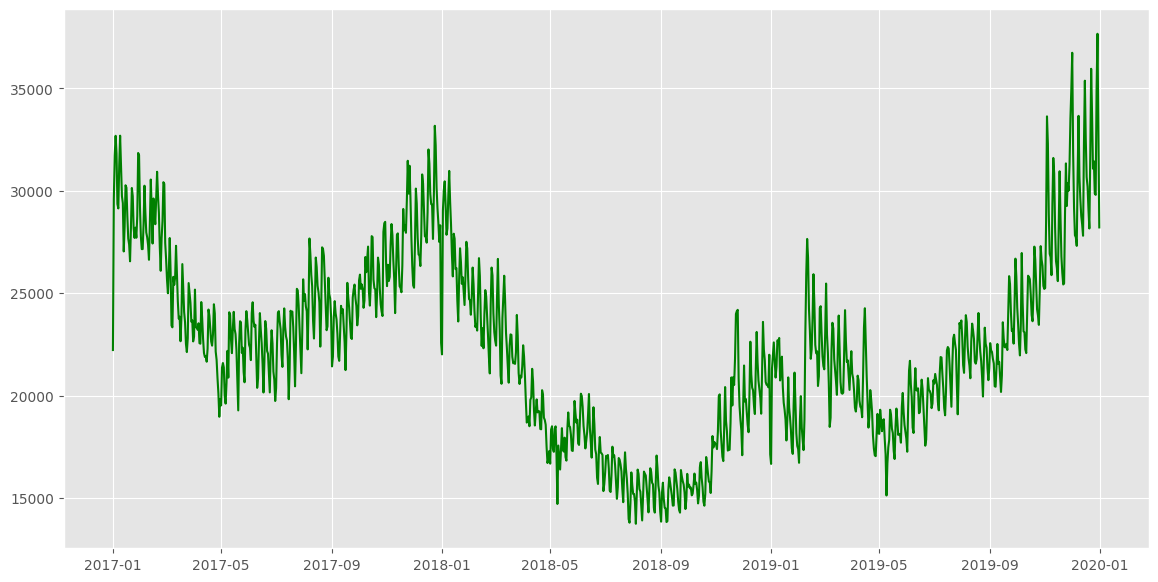

In [ ]:
plt.plot(df, 'g')
plt.show()

In [ ]:
df.head()

,Traffic
Date,
2017-01-01,22226.0
2017-01-02,29593.0
2017-01-03,31726.0
2017-01-04,32684.0
2017-01-05,31820.0


ТЕПЕРЬ НЕОБХОДИМО РАЗДЕЛИТЬ ВРЕМЕННОЙ РЯД НА ПРИМЕРЫ И МЕТКИ

**Date и Traffic - примеры**

**Traffic - метки**

## Получение обучающей валидационной и тестовой выборки

In [ ]:
data = df.copy()
data = np.array(data)

In [ ]:
data.shape

(1095, 1)

In [ ]:
data

array([[22226.],
       [29593.],
       [31726.],
       ...,
       [37665.],
       [32643.],
       [28212.]])

In [ ]:
xLen = 60                         # Анализ по 60 прошедшим точкам 
valLen = 200                      # Использование 400 записей для проверки
trainLen = data.shape[0] - valLen # Размер тренировочной выборки

# Формирование обучающей и тестовой выборок
xTrain, xTest = data[:trainLen], data[trainLen + xLen+2:]
yTrain, yTest = data[:trainLen].reshape(-1,1), data[trainLen + xLen+2:].reshape(-1,1) 

# Масштабирование данных
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# Преобразование размерностей
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

# Создание генератора для обучения
trainDataGen = TimeseriesGenerator(xTrain, # обучающая выборка, экземпляры класса
                                   yTrain, # обучающая выборка, метки класса
                                   length=xLen, # для каждой точки из xLen
                                   stride=1, # сдвиг на 1 элемент
                                   sampling_rate=1, # размер шага на выборке xTrain
                                   batch_size=10 # сколько элементов вернет генератор
                                   )                   

# Создание генератора для валидации
testDataGen = TimeseriesGenerator(xTest, # тестовая выборка, экземпляры класса
                                  yTest, # тестовая выборка, метки класса
                                  length=xLen, # для каждой точки из xLen
                                  stride=1, # сдвиг на 1 элемент
                                  batch_size=10 # сколько элементов вернет генератор
                                  )

# Вывод получившихся размерностей
print(trainDataGen[0][0].shape, trainDataGen[0][1].shape)

# Создание генератора проверочной выборки
DataGen = TimeseriesGenerator(xTest, # тестовая выборка, экземпляры класса
                              yTest, # тестовая выборка, метки класса
                              length=xLen, # для каждой точки из xLen
                              sampling_rate=1, # размер шага на выборке xTest
                              batch_size=len(xTest) # сколько элементов вернет генератор
                              )  

# Формирование проверочной выборки
xVal = []
yVal = []
for i in DataGen:          # [x, y] 
  xVal.append(i[0])        # [0, 1]  
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

(10, 60, 1) (10, 1)


## Сервисные функции

In [ ]:
# Функция расчета результатов прогнозирования сети

def getPred(currModel, # сеть
            xVal, # проверочная выборка, экземпляры класса
            yVal, # проверочная выборка, метки класса
            yScaler # правильные ответы в исходной размерности yValUnscaled
            ):
    
  # Предсказание ответа сети по проверочной выборке
  predVal = yScaler.inverse_transform(currModel.predict(xVal))

  # Использование исходного масштаба данных, до нормализации
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализации графиков, которые предсказала сеть и правильных ответов

def showPredict(start, # точка, с которой начинается отрисовка графика
                step, # длина графика доя визуализации
                channel, # канал для отображения
                predVal, # предсказание ответа сети по проверочной выборке
                yValUnscaled # данные до нормализации
                ):
    
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Дата')
  plt.ylabel('Кол-во пользователей')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции двух одномерных векторов
def correlate(a, # первый вектор
              b # второй вектор
              ):
    
  # Расчет основных показателей
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора

  # corrcoef = np.corrcoef(a, b)
  
  # Расчет корреляции по формуле
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция визуализации корреляции прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции

def showCorr(channels, # по каким каналам отображать корреляцию
             corrSteps, # на какое количество шагов смещать сигнал назад для расчета корреляции
             predVal, # предсказание ответа сети по проверочной выборке
             yValUnscaled # данные до нормализации
             ):
    
  # Проход по всем каналам
  for ch in channels:
    # Создание пустого списка, в котором будут корреляции при смещении на i шагов обратно
    corr = [] 

    # Фиксация размера проверочной выборки
    yLen = yValUnscaled.shape[0]

    # Постепенное увеличение шага смещения сигнала для проверки автокорреляции
    for i in range(corrSteps):

      # Расчет корреляции и добавление в список
      corr.append(correlate(yValUnscaled[:yLen-i,ch], # сравнение с верными ответами, без смещения назад
                            predVal[i:, 0] # сигнал, смещенный на i шагов назад
                            ))
     
    # Создание пустого списка, в котором будут корреляции при смещении на i шагов обратно
    own_corr = [] 

    # Постепенное увеличение шага смещения сигнала для проверки автокорреляции эталона сигнала
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Вывод графика корреляции для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

## Создание и обучение НС

In [ ]:
# Изменение скорости обучения
def scheduler(epoch, lr):
  # На каждой 15-ой эпохе
  if epoch % 15 == 0 and epoch:
    # Изменение скорости обучения на 1 порядок
    lr = round(lr/10, 7)
    print(f'\nМеняем шаг обучения на {lr}\n')
    return lr
  else:
    return lr

# Задание коллбэка
lr_callback = LearningRateScheduler(scheduler)

# Эксперимент №1

In [ ]:
# Создание сети прямого распространения
model = Sequential()

model.add(Dense(150, input_shape = (xLen,1), activation='linear')) # Добавление полносвязного слоя
model.add(Flatten()) # Добавление выравнивающего слоя
model.add(Dense(1)) # Добавление полносвязного слоя

# Компиляция модели
model.compile(loss='mse', optimizer=Adam(lr=1e-4))

# Вывод структуры модели
model.summary()

# Обучение модели
history = model.fit(trainDataGen, # обучающая выборка
                    epochs=45, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data = testDataGen, # проверочная выборка
                    callbacks=[lr_callback] # изменение шага обучения каждые 15 эпох
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 60, 150)           300       
                                                                 
 flatten_1 (Flatten)         (None, 9000)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9001      
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/45
84/84 [==============================] - 1s 5ms/step - loss: 0.0349 - val_loss: 0.0158 - lr: 0.0010
Epoch 2/45
84/84 [==============================] - 1s 8ms/step - loss: 0.0075 - val_loss: 0.0200 - lr: 0.0010
Epoch 3/45
84/84 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0

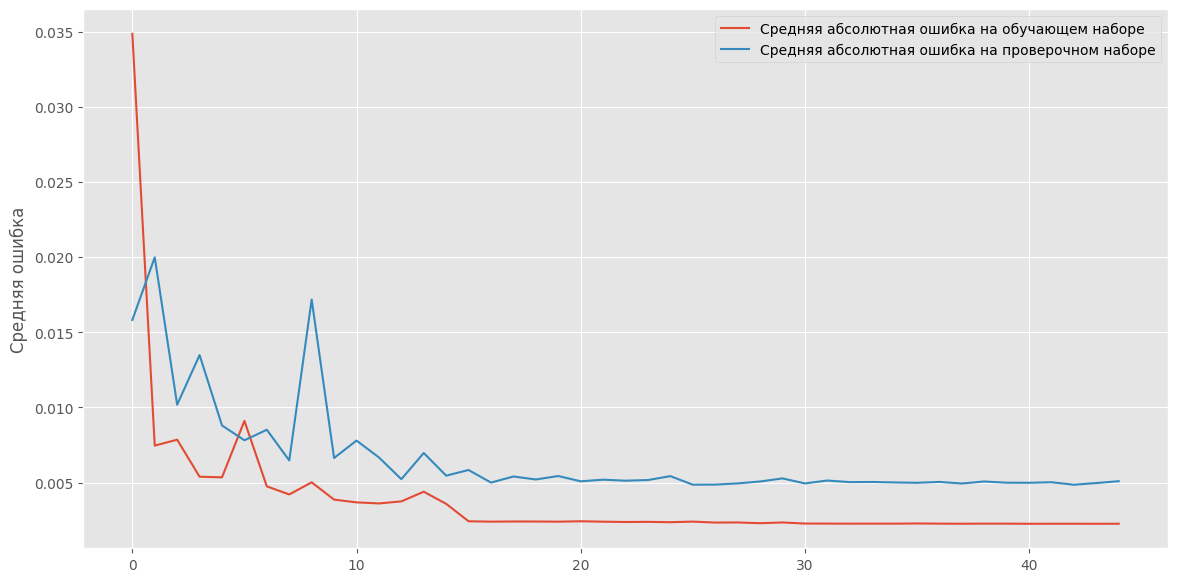

In [ ]:
# Визуализация результатов
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

3/3 [==============================] - 0s 4ms/step


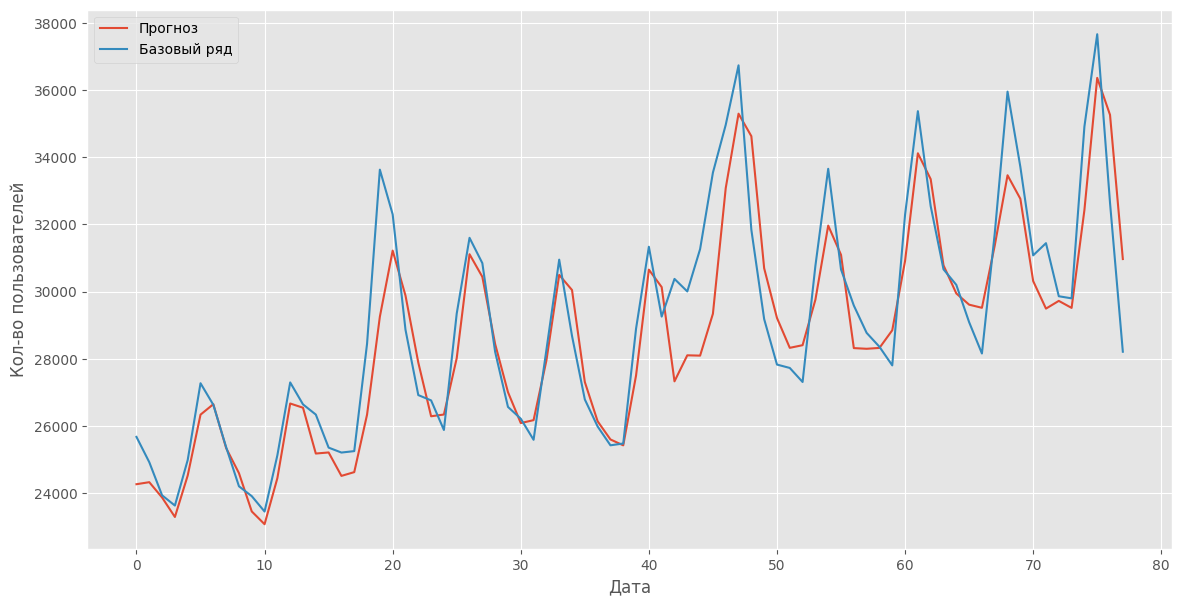

In [ ]:
# Прогноз данных текущей сетью
(predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], yScaler)

# Вывод графиков
showPredict(0, 100, 0, predVal, yValUnscaled)

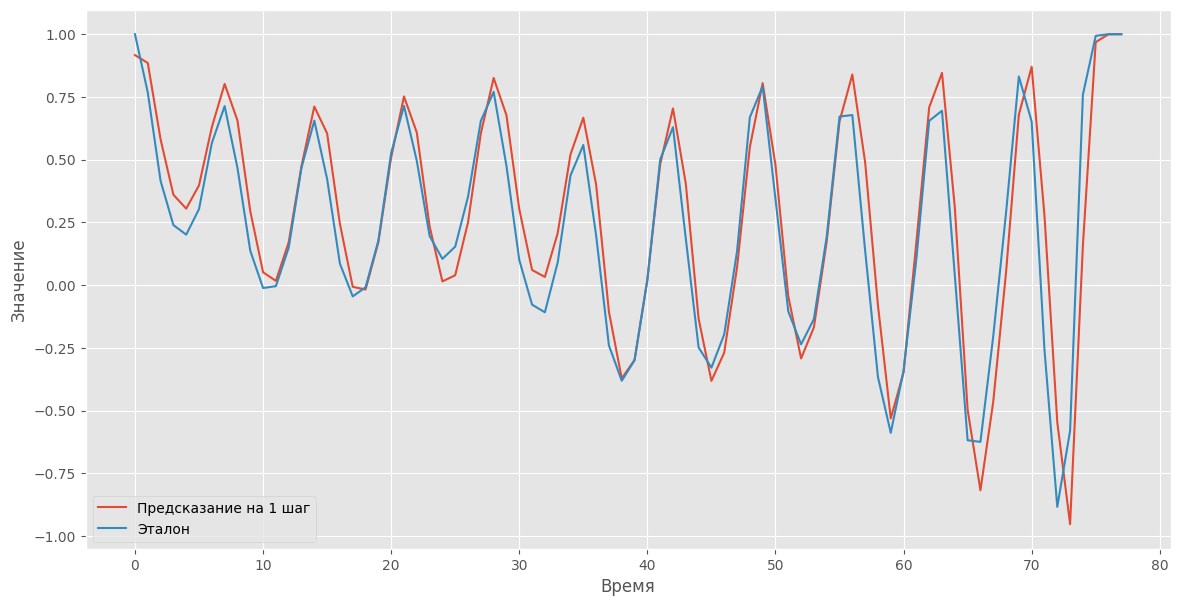

In [ ]:
# График автокорреляции
showCorr([0], 78, predVal, yValUnscaled)

# Эксперимент №2

In [ ]:
# Создание сети прямого распространения
model = Sequential()

# Добавление сверточных слоев
model.add(Conv1D(64, 5, input_shape = (xLen,1), activation='linear'))
model.add(Conv1D(64, 5, activation='linear'))

# Добавление слоя снижения размерностей
model.add(MaxPooling1D())

# Добавление выравнивающего слоя 
model.add(Flatten())

# Добавление полносвязного слоя
model.add(Dense(128, activation='linear'))

# Добавление полносвязного слоя
model.add(Dense(1))

# Компиляция модели
model.compile(loss="mse", optimizer=Adam(lr=1e-4))

# Вывод структуры модели
model.summary()

# Обучение модели
history = model.fit(trainDataGen, # обучающая выборка
                    epochs=45, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=testDataGen, # проверочная выборка
                    callbacks=[lr_callback]) # уменьшение шага обучения каждые 15 эпох)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 52, 64)            20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 64)           0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1664)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               213120    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

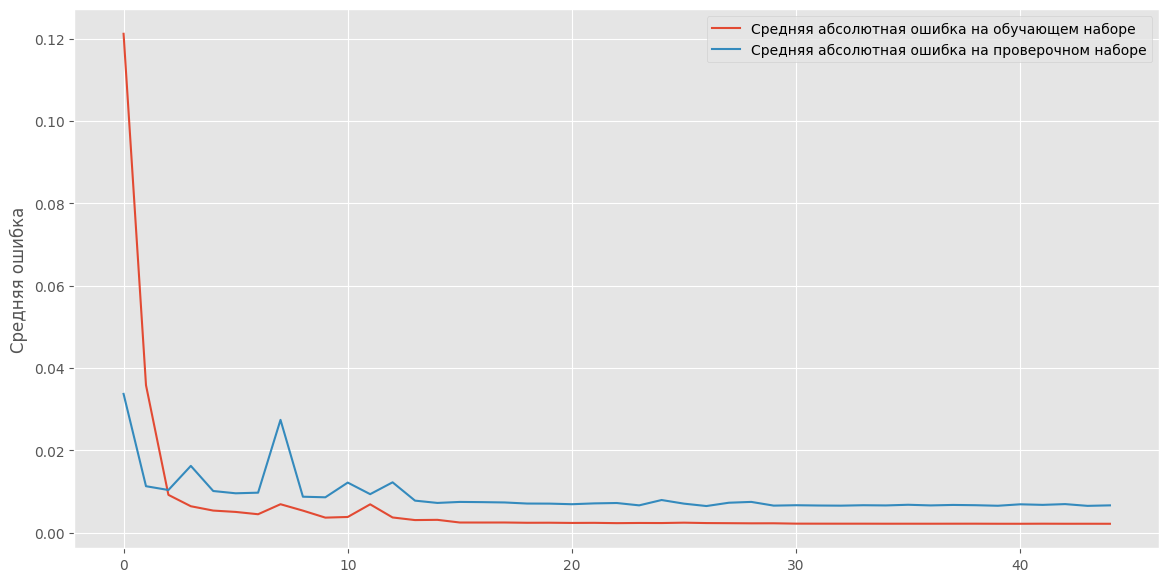

In [ ]:
# Визуализация результатов
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step


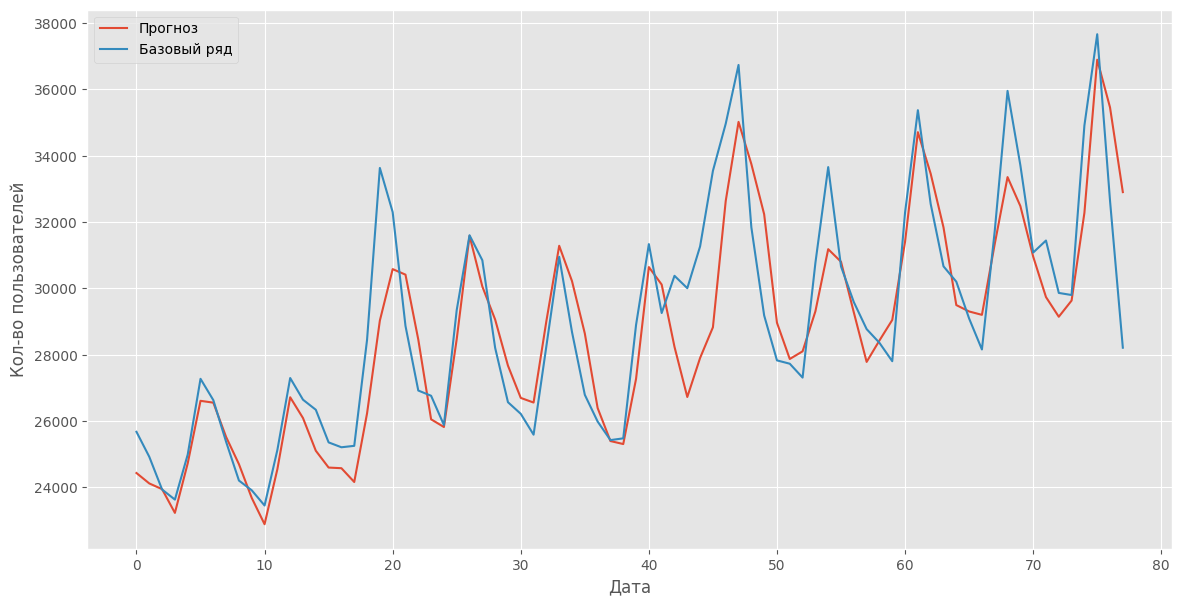

In [ ]:
# Прогноз данных текущей сетью
(predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], yScaler)

# Вывод графиков
showPredict(0, 80, 0, predVal, yValUnscaled)

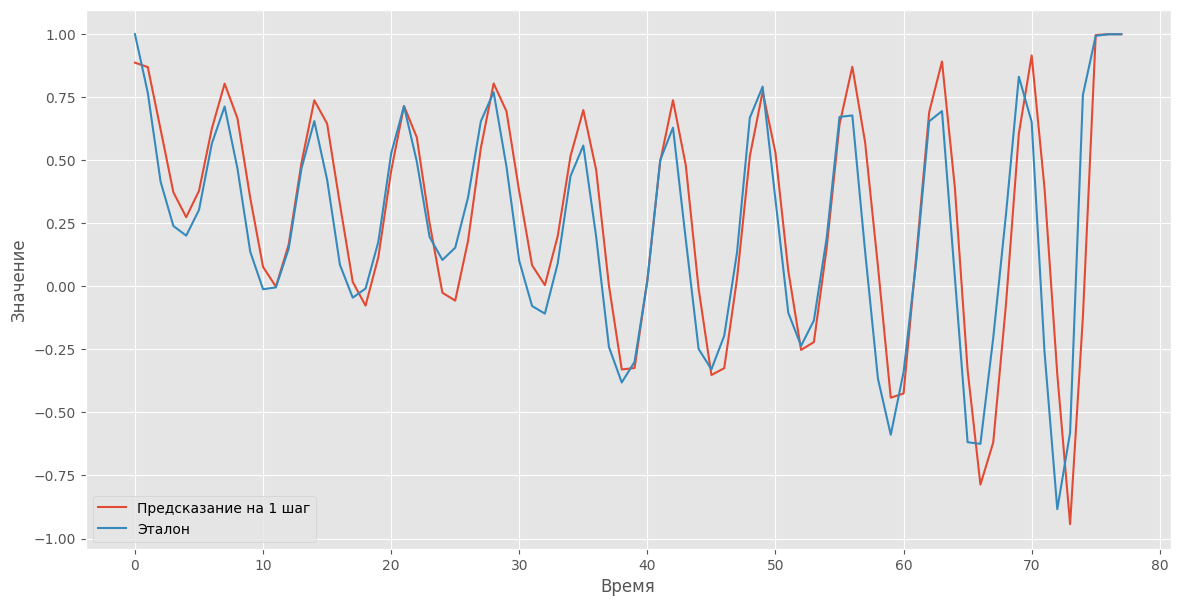

In [ ]:
# График автокорреляции
showCorr([0], 78, predVal, yValUnscaled)

# Эксперимент №3

In [ ]:
# Создание сети прямого распространения
modelC = Sequential()

# Добавление сверточного слоя
modelC.add(Conv1D(2048, 5, input_shape = (xLen,1), activation='linear'))

# Добавление выравнивающего слоя
modelC.add(Flatten())

# Добавление полносвязных слоев
modelC.add(Dense(2048, activation='linear'))
modelC.add(Dense(1, activation='linear'))

# Компиляция модели
modelC.compile(loss='mse', optimizer=Adam(lr=1e-4))

# Обучение модели
history = modelC.fit_generator(
                    trainDataGen, # обучающая выборка
                    epochs=10, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=testDataGen # проверочная выборка
                    )

Epoch 1/10
84/84 [==============================] - 6s 52ms/step - loss: 159.5341 - val_loss: 0.6960
Epoch 2/10
84/84 [==============================] - 4s 48ms/step - loss: 0.1190 - val_loss: 0.2134
Epoch 3/10
84/84 [==============================] - 4s 48ms/step - loss: 0.0509 - val_loss: 0.3781
Epoch 4/10
84/84 [==============================] - 4s 46ms/step - loss: 0.0754 - val_loss: 0.0351
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.0150 - val_loss: 0.0183
Epoch 6/10
84/84 [==============================] - 4s 50ms/step - loss: 0.0115 - val_loss: 0.0216
Epoch 7/10
84/84 [==============================] - 4s 48ms/step - loss: 0.0092 - val_loss: 0.0241
Epoch 8/10
84/84 [==============================] - 4s 48ms/step - loss: 0.0050 - val_loss: 0.0263
Epoch 9/10
84/84 [==============================] - 4s 47ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 10/10
84/84 [==============================] - 4s 46ms/step - loss: 0.0120 - val_loss: 0.0061


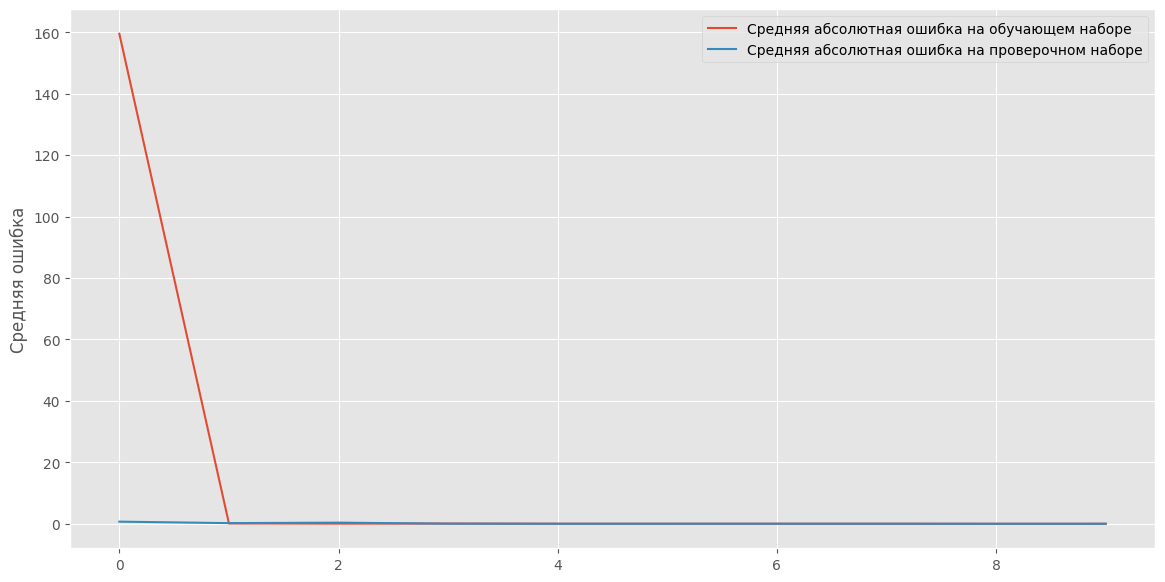

In [ ]:
# Визуализация результатов
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

3/3 [==============================] - 0s 18ms/step


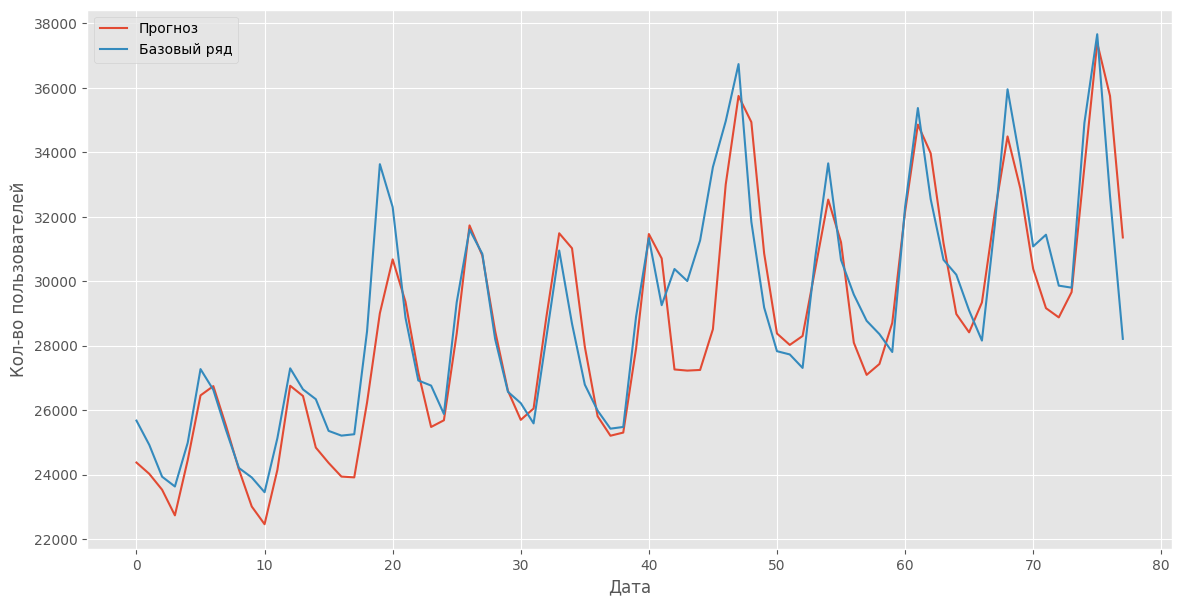

In [ ]:
# Прогноз данных текущей сетью
(predVal, yValUnscaled) = getPred(modelC, xVal[0], yVal[0], yScaler)

# Вывод графиков
showPredict(0, 78, 0, predVal, yValUnscaled)

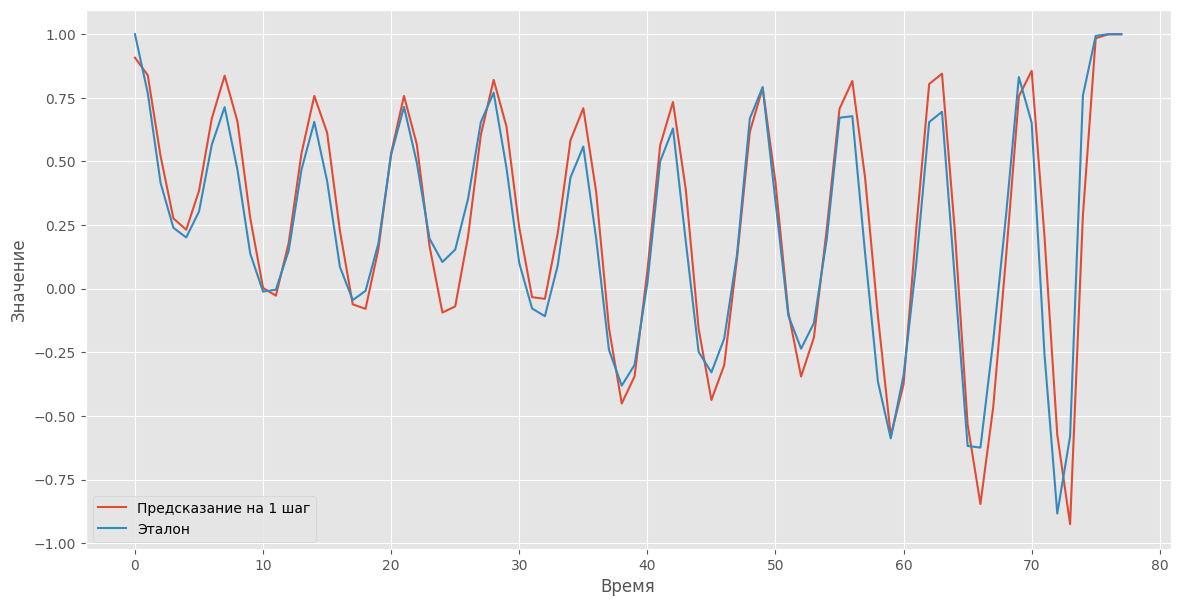

In [ ]:
# График автокорреляции
showCorr([0], 78, predVal, yValUnscaled)